# End-to-End Machine Learning Project

This Jupyter Notebook covers my code and notes from Chapter 2 of Aurelion Geron's *Hands-On Machine Learning with Scikit-Learn & Tensorflow*.

These are the steps we will take:

1. Look at the big picture
2. Get the data
3. Discover and visualize the data to gain insights
4. Prepare the data for Machine Learning algorithms
5. Select the model and train it
6. Fine-tune your model
7. Present your solution
8. Launch, monitor and maintain your system

## Popular Data Repositories

I hope to expand this work to housing datasets from other US states. These are some valuable resources to do so.

- [UC Irvine Machine Learning Repo](http://archive.ics.uci.edu/ml)
- [Kaggle datasets](https://www.kaggle.com/datasets)
- [Amazon's AWS datasets](http://aws.amazon.com/fr/datasets/)

## Look at the Big Picture

We will build a model of housing prices in California using the Califronia census data. In the end, we want our model to predict median housing price in any housing district, given all the other metrics provided in our dataset.

Let's think broadly about the application of this technology. In the book, the author describes a use case where the model's output -- the prediction of median housing price -- will be fed into another Machine Learning system, along with other signals.

I want to think about another use case. Let's make a user-facing application that utilizes our regression model to predict median housing price based on other metrics that we ask the user to enter.

For example, the California housing dataset provides location (latitude and longitude), median income, total rooms, and total bedrooms. How about we create and deploy an application that asks the user what district in California they want to live in, how much they make, and how many bedrooms they want in their room and return a prediction of median housing price. This sounds like a useful piece of information.

Now that we're cooking with gas, let's frame the problem.

### Frame the Problem

It's important to consider what the current solution(s) are before we start creating a new one. In my case, I don't care -- this application example sounds like fun, so we're going to pursue it. In a business case, where this system will pass its results to another downstream system, it's important to discuss how people currently estimate housing prices.

Now let's start designing the system. It is a supervised learning task because we have labeled training examples. We will implement a regression algorithm to predict a value. This regression algorithm will conduct a multivariate analysis because it will use multiple features to make a prediction.

## Select a Performance Measure

Let's take some notes.

A typical performance measure of regression problems is Root Mean Square Error (RMSE). It measures the standard deviation of the errors the system makes in its predictions. Standard deviation is a measure of how spread out the numbers are. By definition is the square root of the variance. The variance is defined as the average of the squared differences from the mean.

Therefore,

$$ RMSE(X, h) = \sqrt{\frac{1}{m} \sum_{i =1}^{m} (h(x^{(i)}) - y^{(i)})^2} $$

where \\(m\\) is the number of instacnes we are measuring the RMSE on, \\( x^{(i)}\\) is a vector of all the feature values for the \\(i\\)th instance in the dataset and \\(y^{(i)} \\) is its corresponding label, \\( X \\) is the matrix containing all of the feature values where the \\(i\\)th row is the transpose of \\(x^{(i)}\\), and h is our prediction function.

We square the differences from the mean so that the negatives don't cancel out the positives. Another approach is to use the average the absolute value of the differences from the mean. This performance measure is called Mean Absolute Error (MEA) and is defined as

$$ MAE(X, h) = \frac{1}{m} \sum_{i = 1}^{m} | h(x^{(i)}) - y^{(i)} | $$


This approach is less sensitive to outliers than RMSE, but typically RMSE is preferred. RMSE and MAE are ways to measure the distance between two vectors: vector of predictions, \\(X\\), and mvector of target values, \\(y\\). Various distance measures, or *norms*, are possible.

Computing the RMSE corresponds to the Euclidean norm -- it is also called the \\(l_2\\) norm. The MAE is also called the \\(l_1\\) norm. In general, the \\(l_k\\) norm is defined 

$$ || v_k ||  = (|v_0|^k + |v_1|^k + \dots + |v_n|^k)^\frac{1}{k} * l_0$$

The higher this norm index, the more it focuses on large values and neglects small ones. This is why RMSE is more sensitive to outliers than MAE. When outliers are exponentially rare -- when the data is in a bell-shaped curve -- RMSE is preferred.

## Download the Data

In the book, the author downloads the data as a tarfile and unzips it. Luckily for us, all Google Colab machines have the California Housing dataset as two csv files -- train and test -- in the sample data directory. Let's read these two datasets into panda dataframes and take a look.

In [3]:
import os
import pandas as pd

HOUSING_PATH = 'sample_data'

def load_housing_data(housing_path=HOUSING_PATH):
  train_path = os.path.join(housing_path, "california_housing_train.csv")
  test_path = os.path.join(housing_path, "california_housing_test.csv")
  return pd.read_csv(train_path), pd.read_csv(test_path)

housing_train, housing_test = load_housing_data()

## Take a Quick Look at the Data

We can take a look at the top five rows of the training set with the DataFrame's `head()` method. There are 9 attributes: `longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, and median_house_value`. The `info()` method gives us a quick description of the data -- we now know that the training set contains 17,000 instances and the test set contains 3,000 instances. These two datasets combine for a total dataset of 20,000 instances and no null values (it looks like Google Colab cleaned the data for us). 

It is also important to note that we shouldn't look at our test set. Doing so may introduce bias, called *data snooping* bias, when we decide to pick a model later.

In [10]:
housing_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [15]:
housing_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


In [13]:
housing_train.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [16]:
housing_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           3000 non-null   float64
 1   latitude            3000 non-null   float64
 2   housing_median_age  3000 non-null   float64
 3   total_rooms         3000 non-null   float64
 4   total_bedrooms      3000 non-null   float64
 5   population          3000 non-null   float64
 6   households          3000 non-null   float64
 7   median_income       3000 non-null   float64
 8   median_house_value  3000 non-null   float64
dtypes: float64(9)
memory usage: 211.1 KB


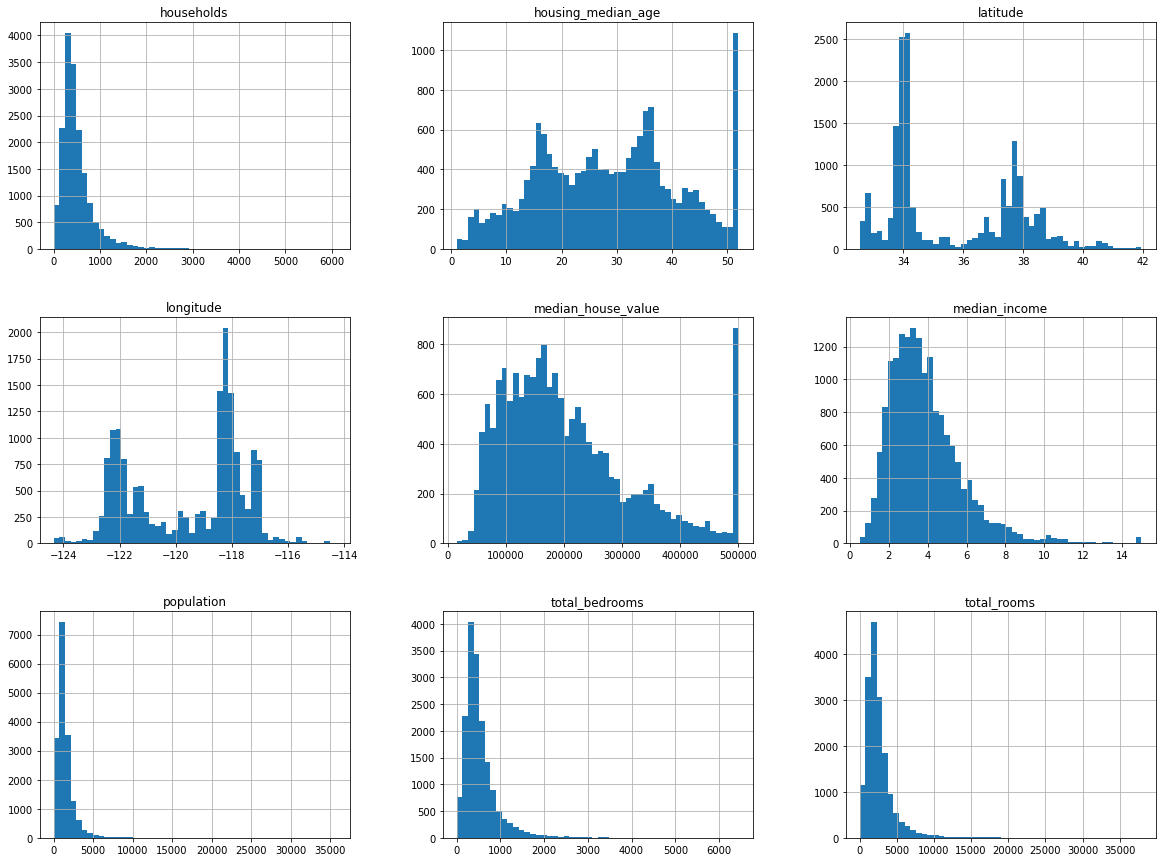

In [5]:
import matplotlib.pyplot as plt
housing_train.hist(bins=50, figsize=(20, 15))
plt.show()

This cursory analysis reveals four main points.

1. The median income attribute has been scaled and capped at 15.0001.
2. The housing median age and median house value were also capped. For this reason, our regression model may learn that prices never go beyond 500,000 dollars.
3. The attributes have different scales.
4. Many histograms -- population, total_bedrooms, total_rooms, and households -- are tail heavy. This may make it harder for some Machine Learning algorithms to detect patterns.

## Create a Test Set

The book goes own to talk about how to create a test set. For our purposes, this is unnecessary because Google Colab has provided us the test set. However, the points the author makes have application beyond this project, so I thought it would be beneficial to discuss them here.

One possible solution is to compute a hash of each instances unique identifier, keep only the last byte of this hash, and put the instance in the test set if this value is lower or equal to a certain threshold.

Here is one possible implementation:

In [ ]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
  return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
  return data.loc[~in_test_set], data.loc[in_test_set]

"""
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')
"""

There is another point to make here. The above is an implementation of a random sampling method. This is generally fine if the dataset is large enough (relative to the number of attributes), but if it is not then we run the risk of sampling bias. An approach that ensures we draw a sample representative of the population is called stratified sampling; we divide the population into homogeneous subgroups or strata.



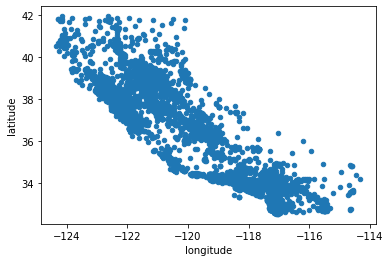

In [19]:
housing_train.plot(kind="scatter", x="longitude", y="latitude")
plt.show()

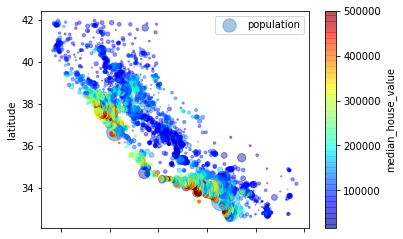

In [8]:
housing_train.plot(kind="scatter", x="longitude", y="latitude", 
             alpha=0.4, s=housing_train['population'] / 100, 
             label="population", c="median_house_value", 
             cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
plt.show()

In [9]:
corr_matrix = housing_train.corr()

In [11]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.691871
total_rooms           0.130991
housing_median_age    0.106758
households            0.061031
total_bedrooms        0.045783
population           -0.027850
longitude            -0.044982
latitude             -0.144917
Name: median_house_value, dtype: float64

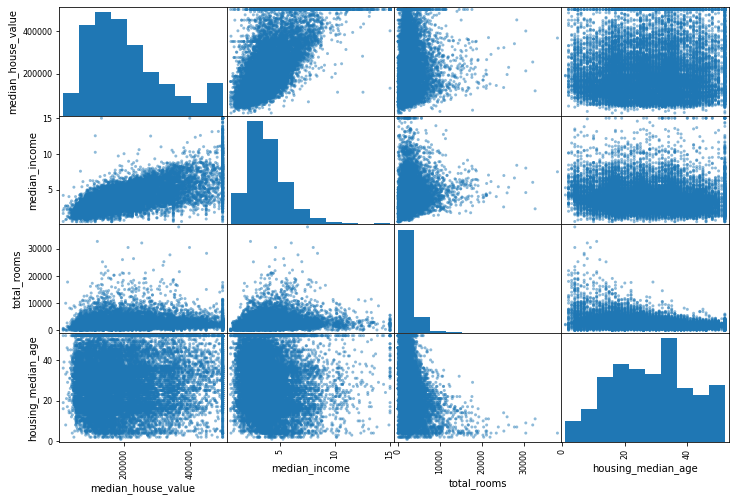

In [15]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

scatter_matrix(housing_train[attributes], figsize=(12, 8))
plt.show()

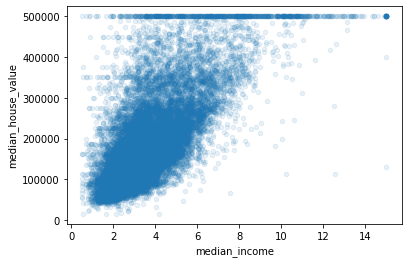

In [17]:
housing_train.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.show()

In [ ]:
housing_train['rooms_per_household'], housing_test['rooms_per_household'] = housing_train['total_rooms'] / housing_train['households'], housing_test['total_rooms'] / housing_test['households']
